# Sentiment Analysis of Call Transcripts

by `Xiaoli Qiu`

Originally created: `2022-01-25`

JIRA: [ONE-10596](https://clearlink.atlassian.net/browse/ONE-10596). <br>

This notebook is duplicated from the original notebook with redundant parts deleted for documentation.


This notebook attempts the sentiment analysis of the call transcripts exported (and processed in the most basic way) from Nexidia.  <br>


## Contents
1. <a href='#read_data'> Read Data </a> <br>
2. <a href='#textblob'> Use TextBlob for Sentiment Analysis </a> <br>  
3. <a href='#gru'> Bi-GRU </a> <br>
4. <a href='#tldr'>TL;DR </a> <br>


In [1]:
import datetime
print('Last time updated: ', datetime.datetime.now())

Last time updated:  2022-09-07 14:37:52.755908


In [2]:
import pandas as pd
import re
import numpy as np
import os

import glob
from collections import defaultdict
# import io

In [3]:
import nltk
from wordcloud import WordCloud

from nltk import punkt
# nltk.data.path.append('.')

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
# from matplotlib import rcParams

In [5]:
import plotly.express as px
import plotly.io as pio

pio.templates.default = "plotly_dark"

In [6]:
import plotly.graph_objs as go
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected = True)
cf.go_offline()

In [7]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.style.use('dark_background')

In [8]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
from nltk.corpus import stopwords

The origianl call transcripts are in txt format, with timestamp on the very left, then identification of speaker (not accurate), then the transcripts on the very right, which could span over multiple rows, not ideal for text procecessing. The `process_scripts_txt_to_pkl` function is used to process the transcripts into dataframe format  where the columns are `time_stamp`, `speaker`, `transcript`  and the very last row of each being the sentiment score by Nexidia. 

In [9]:
def process_scripts_txt_to_pkl(folder="./*.txt"):
    """
    process all transcripts to dataframe format and write them out as pickle files. 
    :param df: dataframe to be processed
    :return: None
    """
    all_files = glob.glob(folder) 
    file_count = 0
    few_lines = 0
    
    for file in all_files: 
        with open(file) as f:
            sl = f.readlines()
        sl_tab = [re.sub(' \s+', '\t', x) for x in sl]
        
        if len(sl_tab) <= 8:
            # skip the transcripts where the conversation is too short
            continue
            
#         print(file)
        line_buff = []
        line_count = 0
        for line in sl_tab[:-2]:  # the last line is sentiment and the 2nd to the last is empty
            line_start = re.match('\d+\t', line).span()[1]
            if line.count('\t')==3:
                line_count += 1
                line_buff.append(line[line_start:].replace('\n', ''))
            else:
                line_buff[line_count-1] += ' ' + line[line_start:].replace('\n', '')
                
        df_lines = pd.read_csv(io.StringIO('\n'.join(line_buff)), sep='\t', header=None, names=['time_stamp', 'speaker', 'transcript'])
        # stored the sentiment score on the last row
        sentiment =  sl_tab[-1].split(':')[1].strip()
        if sentiment is None:
            print(sl_tab[-2:])
        df_lines = df_lines.append({'time_stamp': None, 'speaker': 'sentiment', 'transcript': sentiment}, ignore_index=True)

        # file name
        filename = file.replace('.wav.txt', '.pkl')
        df_lines.to_pickle(filename)
        file_count += 1
        if file_count % 100 == 0:
            print(file_count, 'files processed.')
        
    print(file_count, 'files are processed! All done!')

While `process_scripts_txt_to_pkl` processes the transcripts into better formats, all texts are preseved. `process_transcripts` is used to keep meaningful texts only, i.e, remove stop words and multiple periods. Then `text_to_list` is used as an intermediate function for creating the final dataframe that stores all the clean data, which then to be saved in a csv (`processed_transcripts_includ_period.csv`).

In [10]:
def process_transcripts(cur_trans, stopwords_flag=False, periods_flag=False):
    """
    process transcripts in a dataframe format
    :param cur_trans: dataframe containing the transcripts for processing
    :return: 
    """
    # process the transcripts for TextBlob prediction
    empty = ''
    long_str = [empty+x for x in cur_trans['transcript']]
    long_str = ' '.join(long_str)
    # get rid of special punctuations like multiple '.'
    long_str = re.sub(r'[,!?;.]+', '.', long_str)
    tokenized = nltk.word_tokenize(long_str)
    
    if periods_flag: 
        data_cleaned = [ch.lower() for ch in tokenized if ch.isalpha()]
    else:
        data_cleaned = [ch.lower() for ch in tokenized 
                        if ch.isalpha() 
                        or ch == '.']
    
    stop_words = set(stopwords.words('english'))
    if stopwords_flag:
        meaningful_words = [w for w in data_cleaned if not w in stop_words]
        ss = ' '.join(meaningful_words)
    else: 
        ss = ' '.join(data_cleaned)

    return ss

In [11]:
def text_to_list(folder_path, cancelled_flag, stopwords_flag=True, periods_flag=False):
    """
    Process all the transcripts into a dataframe 
    :param folder_path: path for the transcripts to be processed
    :param cancelled_flag: whether the orders were cancelled for the calls in that folder
    :param stopwords_flag: whether to get rid of stop words, used in process_transcripts() function
    :param periods_flag: whether to get rid of all periods, used in process_transcripts() function
    :return: dataframe with two columns: (1) call transcripts, (2) whethere the order was cancelled or not
    """
    all_files = glob.glob(folder_path) 
    file_count = 0
    corpus = []
    
    for file in all_files: 
        file_count += 1
        contact_id = os.path.basename(file).split('.')[0]
        cur_trans = pd.read_pickle(file)
        text = process_transcripts(cur_trans, stopwords_flag, periods_flag)
        sentiment = int(cur_trans.loc[len(cur_trans)-1, 'transcript'])
        corpus.append([contact_id, text, cancelled_flag, sentiment])
        
    print(file_count, 'transcripts processed.')
    return corpus

In [27]:
# text_flag = [['./SoldTranscripts/*.pkl', 1], ['./UnsoldTranscripts/*.pkl', 0]]
# all_processed = []
# for i in range(len(text_flag)):
#     # include period
#     corpus = text_to_list(text_flag[i][0], text_flag[i][1], True, False)
#     all_processed += corpus

# df_nn = pd.DataFrame(all_processed, columns=['contact_id', 'Transcripts', 'Sold_flag', 'sentiment'])
# df_nn

506 transcripts processed.
498 transcripts processed.


contact_id                                        Transcripts  \
0     194837251851  thank contacting centurylink name steve . plea...   
1     194837253196  thank choosing centurylink name like . speakin...   
2     194837254787  thank calling . direct tv . name dominic . spe...   
3     194837256249  . calling . tv services name jessica speaking ...   
4     194837259691  thank choosing centurylink scott . authorized ...   
...            ...                                                ...   
999   194933652612  thank choosing unk . name question . actually ...   
1000  194933654577  yeah pleasure speaking today hello thank . nam...   
1001  194933654709  . name . um . . road . today . pretty good try...   
1002  194933656780  choosing centurylink . name isaac home special...   
1003  194933657888  hello thank calling unk name . pleasure speaki...   

      Sold_flag  sentiment  
0             1          1  
1             1          1  
2             1          1  
3             1          2  
4             1          2  
...         ...        ...  
999           0          2  
1000          0         -1  
1001          0          0  
1002          0         -1  
1003          0          0  

[1004 rows x 4 columns]

In [28]:
# df_nn.to_csv('processed_transcripts_includ_period.csv', index=False)

In [12]:
df_nn = pd.read_csv('processed_transcripts_includ_period.csv')

In [13]:
def generate_word_cloud(text):
    wordcloud = WordCloud(
        width = 3000,
        height = 1500,
        background_color = 'black').generate(str(text))
    fig = plt.figure(
        figsize = (15, 8),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

In [14]:
def min_max_score(folder): 
    """
    Find the lowest and highest sentiment scores. 
    :param folder: directory of the files to be examined
    return: None
    """
    min_score = 0
    max_score = 0
    all_files = glob.glob(folder) 
    for file in all_files:
        df = pd.read_pickle(file)
        sentiment = int(df['transcript'].iloc[-1])
        if sentiment < min_score:
            min_score = sentiment
        elif sentiment > max_score:
            max_score = sentiment
    print('Min: ', min_score, '; Max: ', max_score)        

In [15]:
print('Highest and lowest sentiment scores for sold transcripts: ')
# min_max_score('./SoldTranscripts/*.pkl')
df_nn[df_nn['Sold_flag']==1]['sentiment'].apply(['min', 'max'])

Highest and lowest sentiment scores for sold transcripts: 


min   -2
max    9
Name: sentiment, dtype: int64

In [16]:
print('Highest and lowest sentiment scores for unsold transcripts: ')
# min_max_score('./UnsoldTranscripts/*.pkl')
df_nn[df_nn['Sold_flag']==0]['sentiment'].apply(['min', 'max'])

Highest and lowest sentiment scores for unsold transcripts: 


min   -6
max    7
Name: sentiment, dtype: int64

Unsold ones could still have very postive sentiments. 

In [17]:
def count_sentiment_scores(folder):
    """
    Aggregate the counts of sentiment scores
    :param folder: directory of the files to be examined
    return: a dictionary {sentiment_score: counts}
    """
    counts = {}
    all_files = glob.glob(folder) 
    for file in all_files:
        df = pd.read_pickle(file)
        sentiment = int(df['transcript'].iloc[-1])
        if sentiment not in counts:
            counts[sentiment] = 1
        else:
            counts[sentiment] += 1
            
    return counts

In [18]:
# sentiments_sold = count_sentiment_scores('./SoldTranscripts/*.pkl')
# sentiments_unsold = count_sentiment_scores('./UnsoldTranscripts/*.pkl')
# df_sentiment_sold_count = pd.DataFrame(list(sentiments_sold.items()), columns=['sentiment_score', 'counts'])
# df_sentiment_unsold_count = pd.DataFrame(list(sentiments_unsold.items()), columns=['sentiment_score', 'counts'])

In [19]:
df_nn

contact_id                                        Transcripts  \
0     194837251851  thank contacting centurylink name steve . plea...   
1     194837253196  thank choosing centurylink name like . speakin...   
2     194837254787  thank calling . direct tv . name dominic . spe...   
3     194837256249  . calling . tv services name jessica speaking ...   
4     194837259691  thank choosing centurylink scott . authorized ...   
...            ...                                                ...   
999   194933652612  thank choosing unk . name question . actually ...   
1000  194933654577  yeah pleasure speaking today hello thank . nam...   
1001  194933654709  . name . um . . road . today . pretty good try...   
1002  194933656780  choosing centurylink . name isaac home special...   
1003  194933657888  hello thank calling unk name . pleasure speaki...   

      Sold_flag  sentiment  
0             1          1  
1             1          1  
2             1          1  
3             1          2  
4             1          2  
...         ...        ...  
999           0          2  
1000          0         -1  
1001          0          0  
1002          0         -1  
1003          0          0  

[1004 rows x 4 columns]

In [20]:
df_sentiment_sold_count = df_nn[df_nn['Sold_flag']==1].groupby(['sentiment']).agg({'contact_id': lambda x:x.nunique()}).reset_index()
df_sentiment_sold_count.rename(columns={'sentiment': 'sentiment_score', 'contact_id': 'counts'}, inplace=True)
df_sentiment_unsold_count = df_nn[df_nn['Sold_flag']==0].groupby(['sentiment']).agg({'contact_id': lambda x:x.nunique()}).reset_index()
df_sentiment_unsold_count.rename(columns={'sentiment': 'sentiment_score', 'contact_id': 'counts'}, inplace=True)

In [21]:
fig = go.Figure(data=[
    go.Bar(name='Unsold', x=df_sentiment_unsold_count['sentiment_score'], y=df_sentiment_unsold_count['counts']),
    go.Bar(name='Sold', x=df_sentiment_sold_count['sentiment_score'], y=df_sentiment_sold_count['counts'])
])
fig.update_layout(barmode='group', legend = dict(bgcolor = 'LightSteelBlue'))
fig.show()

From the Nexidia group, 'Sold' ones do seem to be more towards the positive side compared to the 'Unsold' ones. Not many ones with negative sentiment scores.

In [189]:
# !pip install textblob

In [23]:
from textblob import TextBlob
# function to calculate subjectivity
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity
    # function to calculate polarity
    def getPolarity(review):
        return TextBlob(review).sentiment.polarity

# function to analyze the reviews
def analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

<a id='textblob'> </a>

# Use TextBlob for Sentiment Analysis

Compare the score output by TextBlob to Nexidia's.

TextBlob assesses the sentiments on tokens (unigrams only). 

__Note:__ pickle files produced from the process_scripts_txt_to_pkl function (as well as the orignal txt files for the call transcripts are not given in this repository).

In [26]:
# def get_sentiment_scores_old(folder="./*.pkl", stop_words_flag=False, periods_flag=False):
#     """
#     process all transcripts to dataframe format and write them out as pickle files. 
#     :param df: dataframe to be processed
#     :return: the predicted sentiment score and the difference between the prediction and the Nexidia sentiment score
#     """
#     all_files = glob.glob(folder) 
#     file_count = 0
#     sentiments = {}
#     gap_sentiments = {}
    
#     for file in all_files: 
#         cur_trans = pd.read_pickle(file)
        
#         # Sentiment score by Nexidia
#         y = int(cur_trans['transcript'].iloc[-1])
        
#         # process the transcripts for TextBlob prediction
#         ss = process_transcripts(cur_trans, stop_words_flag, periods_flag)
#         pred = TextBlob(ss).sentiment.polarity
        
#         if file not in sentiments:
#             sentiments[file] = (y, pred*10)
#             if (abs(y- pred*10) > 2) and file not in gap_sentiments:
#                 gap_sentiments[file] = (y, pred*10)
        
#         file_count += 1
#         if file_count % 100 == 0:
#             print(file_count, 'transcripts predicted.')
            
#     return sentiments, gap_sentiments

In [24]:
def get_sentiment_scores(df):
    """
    process all transcripts to dataframe format and write them out as pickle files. 
    :param df: dataframe to be processed
    :return: the predicted sentiment score and the difference between the prediction and the Nexidia sentiment score
    """
    sentiments = {}
    gap_sentiments = {}
    row_count = 0
    
    for row in df.itertuples():
        contact_id = row.contact_id
        # current transcripts
        cur_trans = row.Transcripts
        
        # Sentiment score by Nexidia
        y = int(row.sentiment)
                
        # TextBlob prediction
        pred = TextBlob(cur_trans).sentiment.polarity
        
        if contact_id not in sentiments:
            sentiments[contact_id] = (y, pred*10)
            if (abs(y- pred*10) > 2) and contact_id not in gap_sentiments:
                gap_sentiments[contact_id] = (y, pred*10)
        
        row_count += 1
        if row_count % 100 == 0:
            print(row_count, 'transcripts predicted.')
            
    return sentiments, gap_sentiments

In [25]:
sentiments, gap_sentiments = get_sentiment_scores(df_nn)

100 transcripts predicted.
200 transcripts predicted.
300 transcripts predicted.
400 transcripts predicted.
500 transcripts predicted.
600 transcripts predicted.
700 transcripts predicted.
800 transcripts predicted.
900 transcripts predicted.
1000 transcripts predicted.


In [26]:
# where the absolute difference is larger than 2
gap_sentiments

{194837251851: (1, 3.3675496031746026),
 194837263270: (0, 2.937125541125541),
 194837270063: (-1, 2.5670965845178455),
 194837282005: (1, 3.354223939077955),
 194837282526: (1, 3.338913234005258),
 194837296550: (0, 2.587176170183983),
 194837300036: (5, 2.7691569598786088),
 194837316613: (0, 2.138532586135327),
 194837327916: (1, 3.157873156653646),
 194837337807: (1, 3.155020088843621),
 194837341184: (6, 2.3293636363636363),
 194837362397: (0, 3.057692307692308),
 194837370191: (1, 3.047619047619048),
 194837371220: (0, 2.509693294127258),
 194837376595: (5, 2.409346073980219),
 194837408593: (1, 3.1707706234575372),
 194837412146: (0, 2.663820960363515),
 194837413213: (1, 3.0693189299180093),
 194837418345: (1, 3.104563381403872),
 194837421647: (0, 2.2263676323676314),
 194837430481: (1, 3.1123505918859893),
 194837444418: (1, 3.3858500106450933),
 194837446799: (-1, 3.1432162074685426),
 194837450282: (0, 2.7208579299488385),
 194837471781: (0, 2.142937135328439),
 19483747541

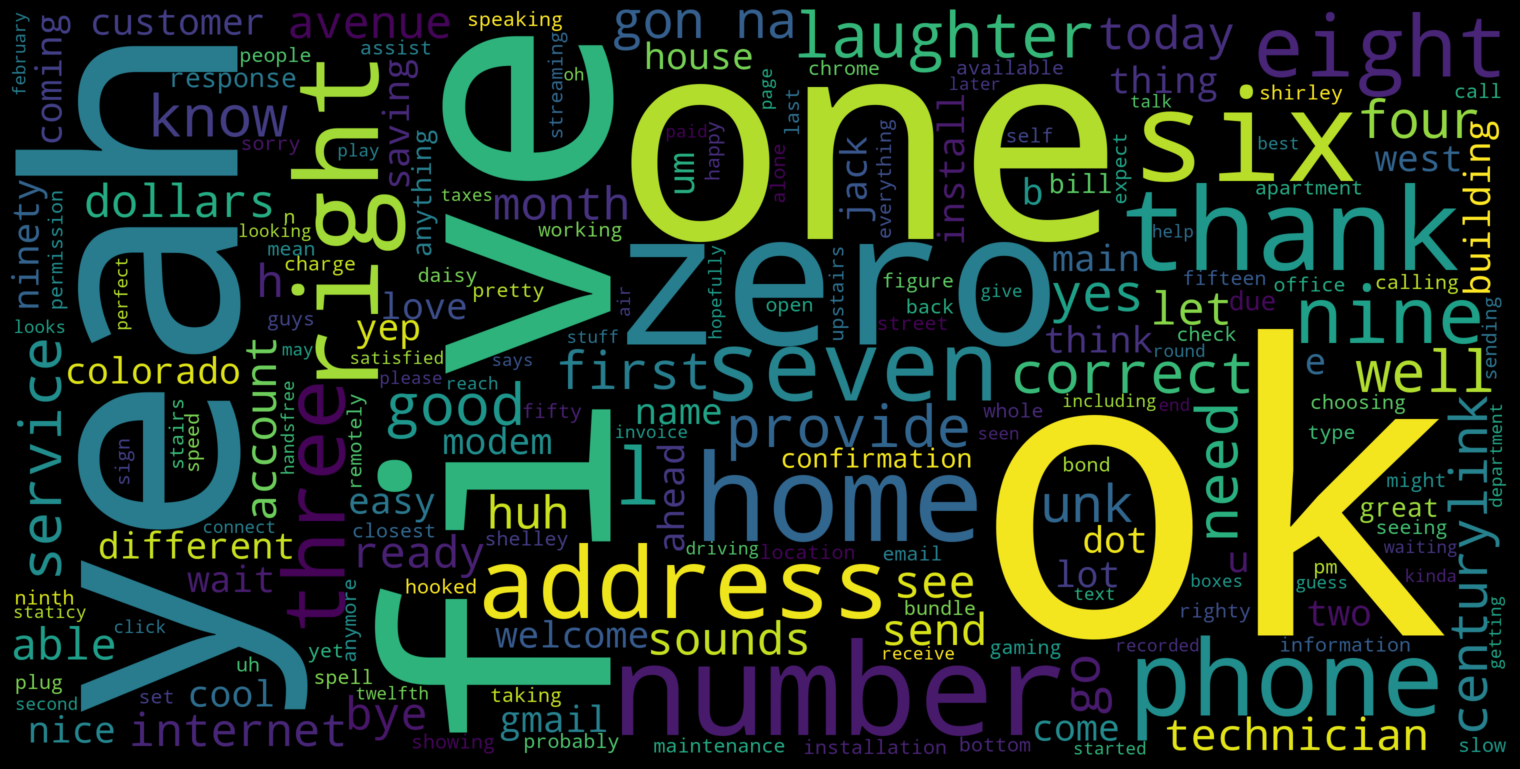

In [27]:
#  194838437935: (7, 3.9014057750759874),
ss_pos = df_nn[df_nn['contact_id']==194838437935]['Transcripts'].values[0]
generate_word_cloud(ss_pos)

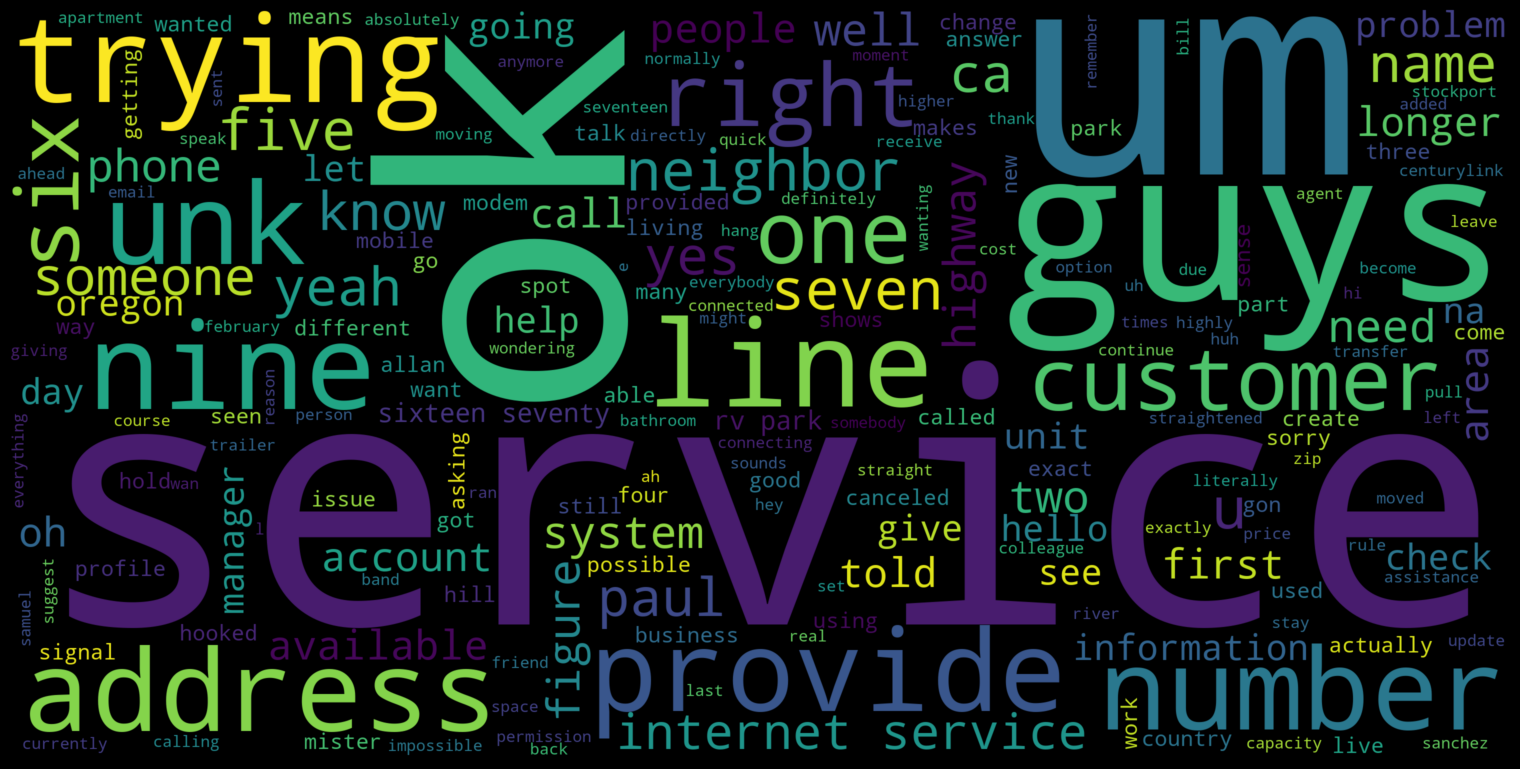

In [28]:
# 194838474597: (-3, 2.5561877705627705),
ss_neg = df_nn[df_nn['contact_id']==194838474597]['Transcripts'].values[0]
generate_word_cloud(ss_neg)

In [29]:
STOPWORDS = set(stopwords.words('english'))

In [30]:
def generate_ngrams(text, n_gram=1):
    # remove all periods
    text = re.sub(r'[,!?;.]+', '', text)
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

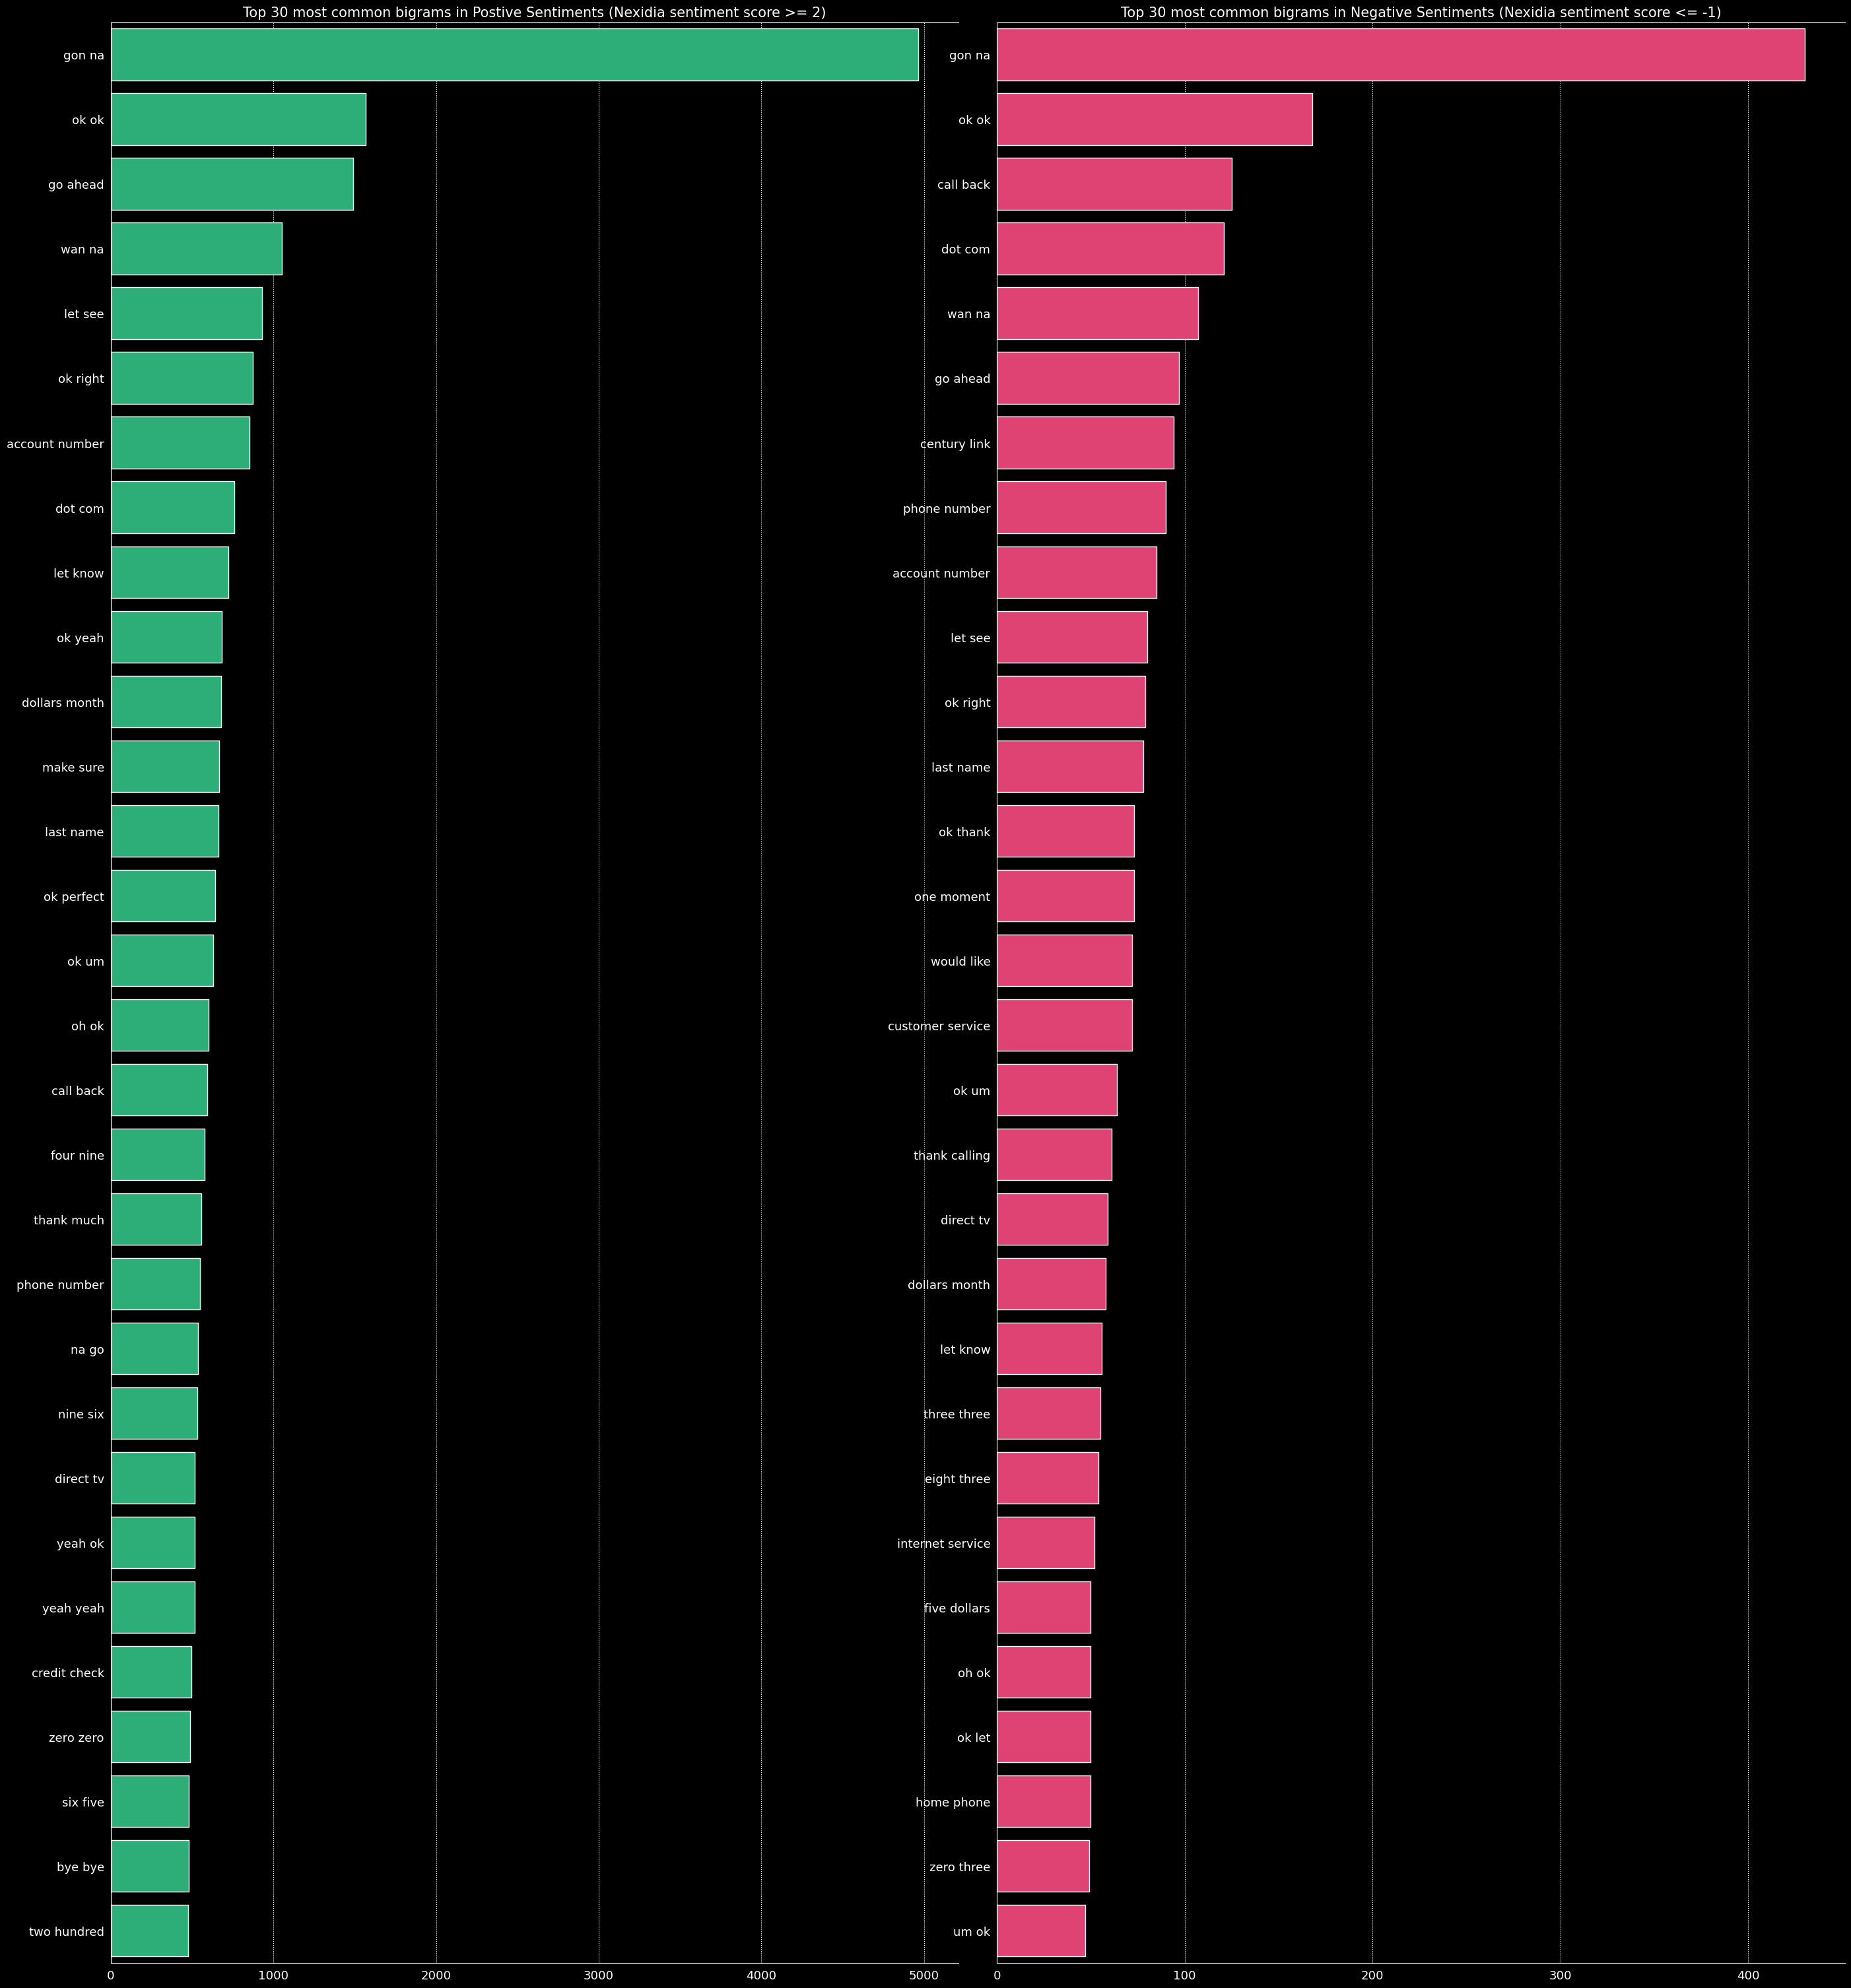

In [31]:
# Bigrams
positive_bigrams = defaultdict(int)
negative_bigrams = defaultdict(int)
n_grams = 2
N = 30 

for text_vals in df_nn[df_nn['sentiment']>=2]['Transcripts']:
    for word in generate_ngrams(text_vals, n_gram=n_grams):
        positive_bigrams[word] += 1
        
for text_vals in df_nn[df_nn['sentiment']<=-1]['Transcripts']:
    for word in generate_ngrams(text_vals, n_gram=n_grams):
        negative_bigrams[word] += 1
        
        
df_positive_bigrams = pd.DataFrame(sorted(positive_bigrams.items(), key=lambda x: x[1])[::-1])
df_negative_bigrams = pd.DataFrame(sorted(negative_bigrams.items(), key=lambda x: x[1])[::-1])

fig, axes = plt.subplots(ncols=2, figsize=(27, 30), dpi=100, facecolor = 'k', edgecolor = 'k')
plt.tight_layout()

sns.barplot(y=df_positive_bigrams[0].values[:N], x=df_positive_bigrams[1].values[:N], ax=axes[0], color='#17C37B')
sns.barplot(y=df_negative_bigrams[0].values[:N], x=df_negative_bigrams[1].values[:N], ax=axes[1], color='#F92969')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Postive Sentiments (Nexidia sentiment score >= 2)', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Negative Sentiments (Nexidia sentiment score <= -1)', fontsize=15)

plt.show()

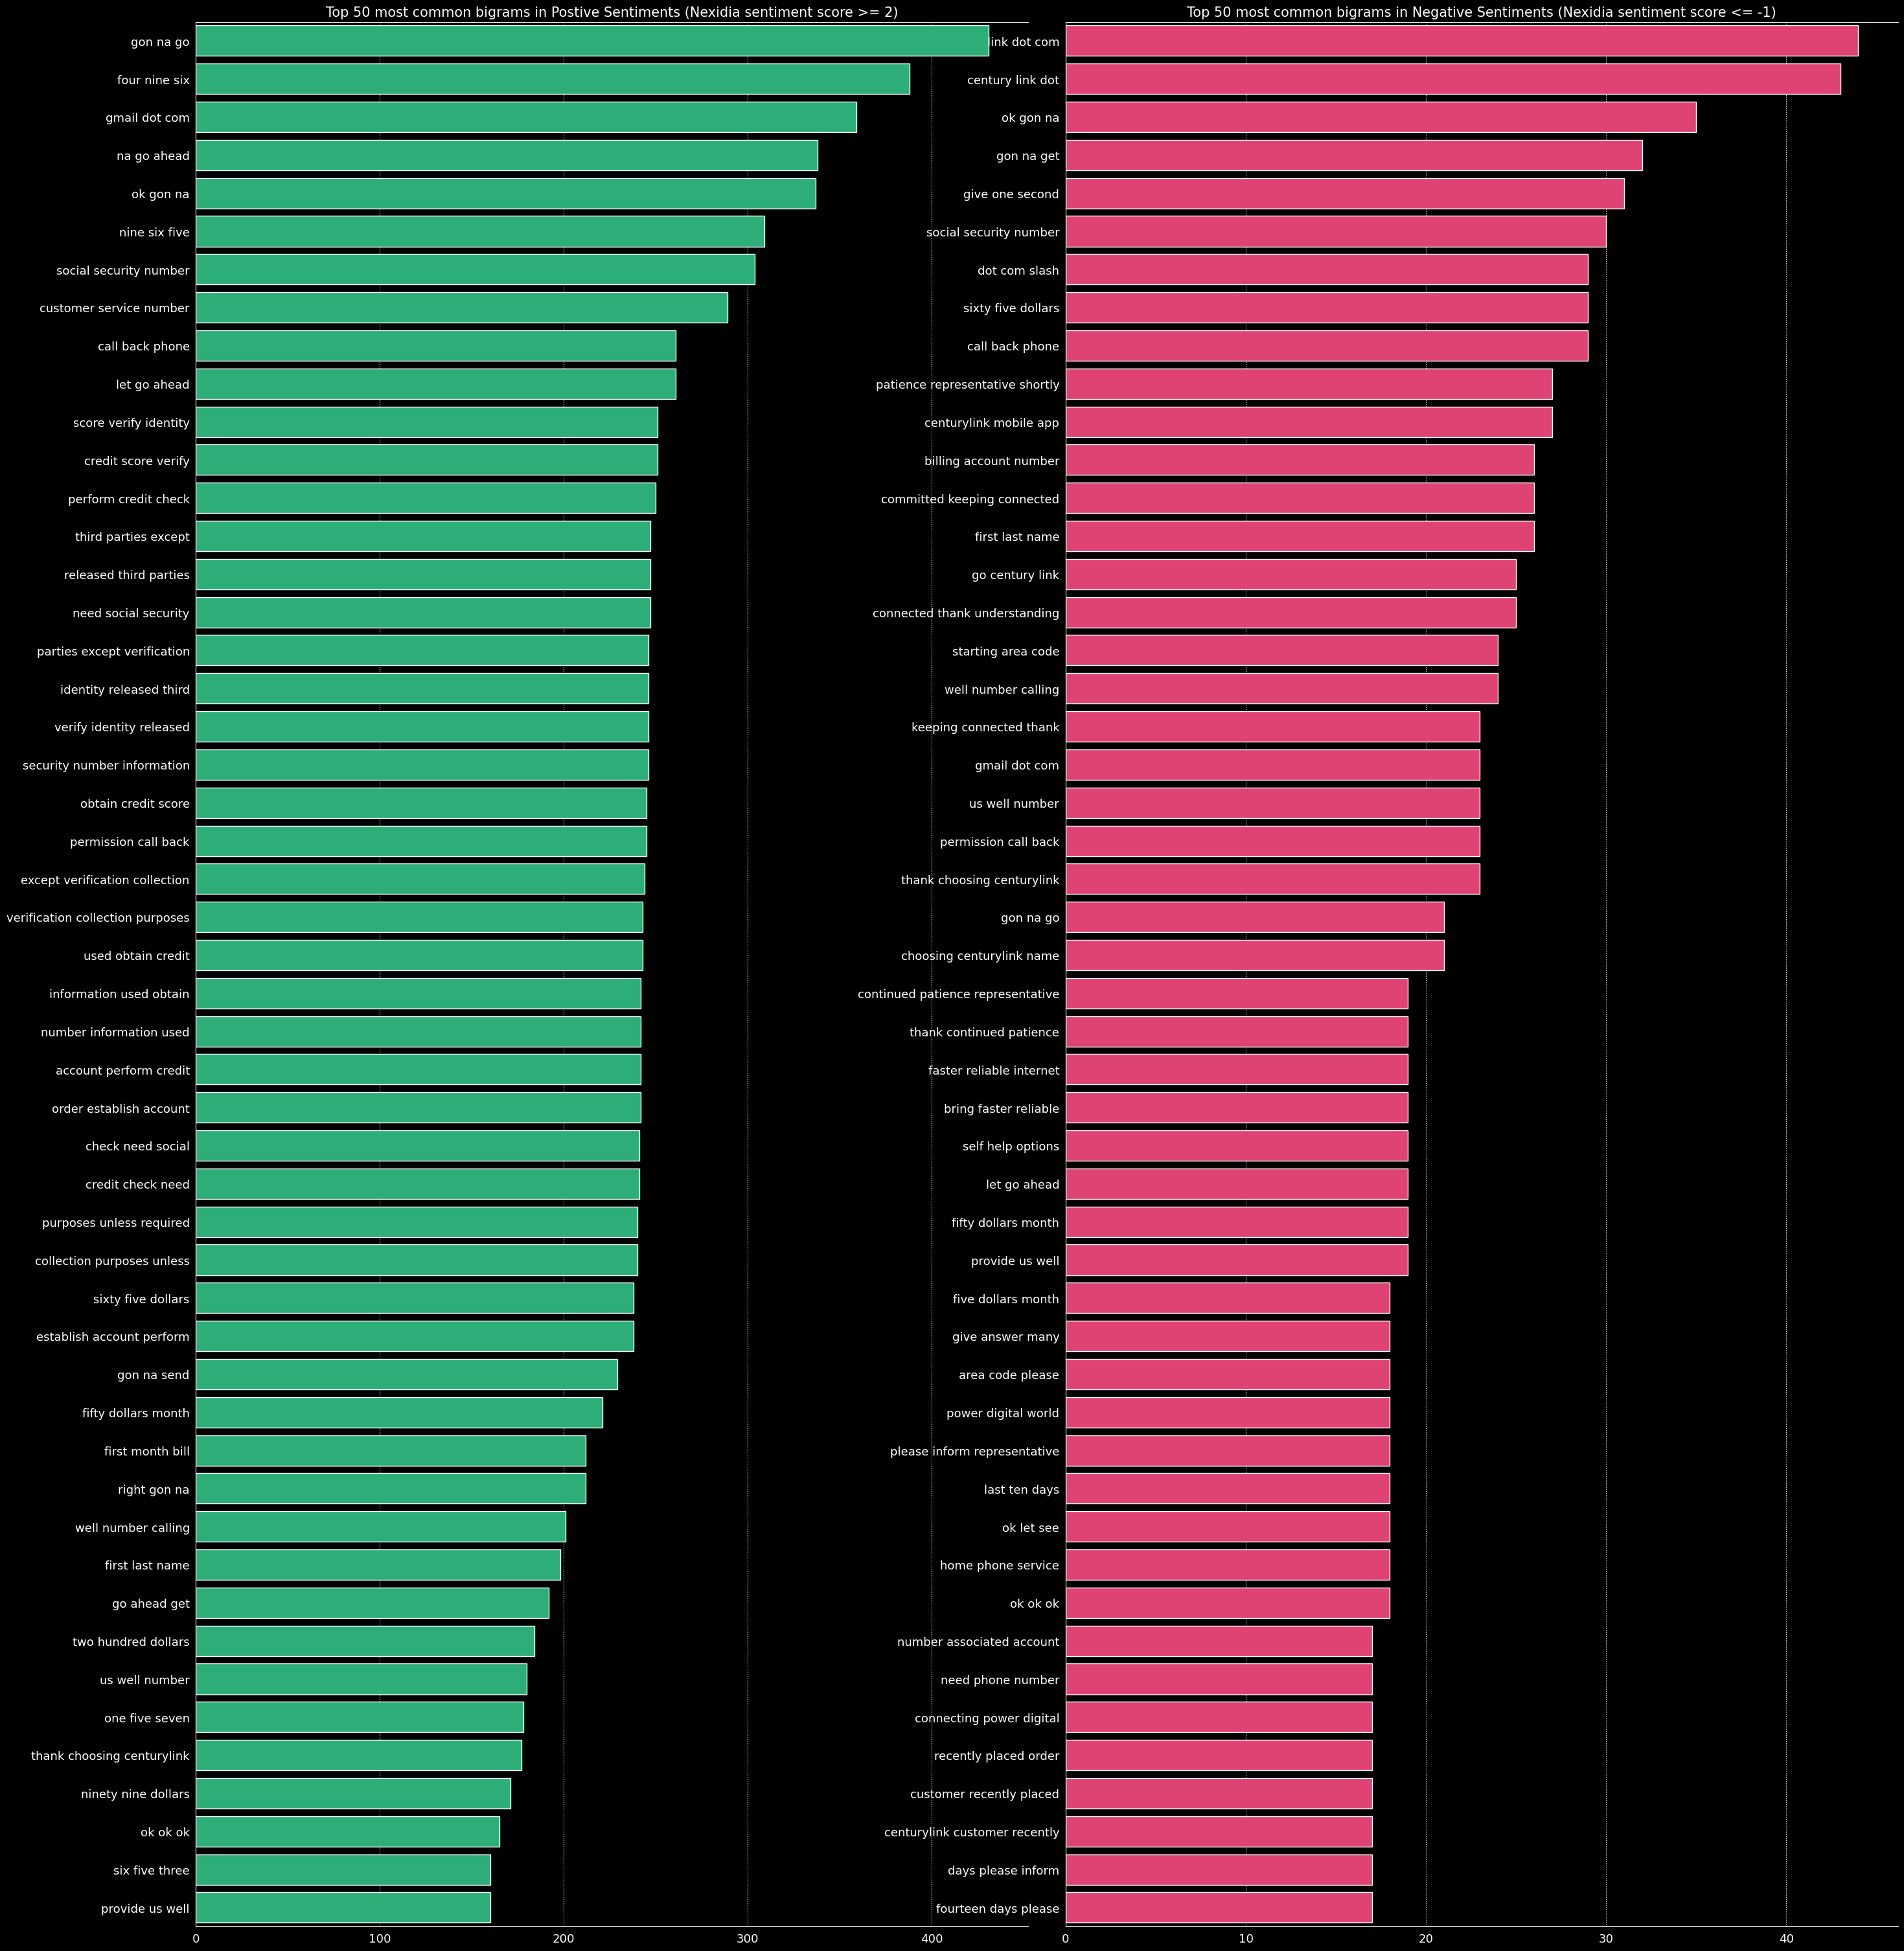

In [32]:
# Trigrams
positive_trigrams = defaultdict(int)
negative_trigrams = defaultdict(int)
n_grams = 3
N = 50 

for text_vals in df_nn[df_nn['sentiment']>=2]['Transcripts']:
    for word in generate_ngrams(text_vals, n_gram=n_grams):
        positive_trigrams[word] += 1
        
for text_vals in df_nn[df_nn['sentiment']<=-1]['Transcripts']:
    for word in generate_ngrams(text_vals, n_gram=n_grams):
        negative_trigrams[word] += 1
        
        
df_positive_trigrams = pd.DataFrame(sorted(positive_trigrams.items(), key=lambda x: x[1])[::-1])
df_negative_trigrams = pd.DataFrame(sorted(negative_trigrams.items(), key=lambda x: x[1])[::-1])

fig, axes = plt.subplots(ncols=2, figsize=(27, 30), dpi=100, facecolor = 'k', edgecolor = 'k')
plt.tight_layout()

sns.barplot(y=df_positive_trigrams[0].values[:N], x=df_positive_trigrams[1].values[:N], ax=axes[0], color='#17C37B')
sns.barplot(y=df_negative_trigrams[0].values[:N], x=df_negative_trigrams[1].values[:N], ax=axes[1], color='#F92969')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Postive Sentiments (Nexidia sentiment score >= 2)', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Negative Sentiments (Nexidia sentiment score <= -1)', fontsize=15)

plt.show()

In [46]:
# nltk.pos_tag(ss.split())

Due to incomplete transcripts (missing a lot of words), POS is not accurate. `('do', 'NN')` (following after 'what kind of')

## Summary for TextBlob

There are huge differences between the sentiment prediction by TextBlob and the Nexidia's, which is understandable as TextBlob is not very sophisticated (evaluation based on individual words) and the frequency plots of N-grams also support that.  

<a id='gru'> </a>
  
# Bi-GRU

The sentiment scores by Nexidia are used as the source of truth in this section: <br>
- (- $\infty$, -2] is considered as negative <br>
-  (-2, 2) is considered as neutral <br>
- [2, $\infty$) is considered as positive <br>

Train a Bi-directional Gated Recurrent Unit Network to classfy the call transcripts into the 3 categories. 

In [116]:
# Take a look at the calls with sentiment of 2 or -2 
# df_ns = df_nn[(df_nn['sentiment']==-2) | (df_nn['sentiment']==2)].copy()
# df_ns = df_nn[(df_nn['sentiment']==-1)].copy()
# for row in df_ns.itertuples():
#     print('Contact_id', row.contact_id)
#     print('Sold yes? ', row.Sold_flag)
#     print('Nexidia sentiment score: ', row.sentiment)
#     print(row.Transcripts)
#     print('---------------------')

In [33]:
# Classifiy the ones with sentiment score of 2 or higher as positive, -2 or lower as negative and the rest as netrual
def sentiment_class(score):
    if score >= 2:
        result = 1
    elif score <= -2:
        result = -1
    else:
        result = 0
        
    return result

In [34]:
df_nn['sentiment_flag'] = df_nn['sentiment'].apply(sentiment_class)

In [35]:
# Take a look at the sentiment scores in each class
df_nn.groupby(by=['sentiment_flag'])['sentiment'].agg(['min', 'max'])

min  max
sentiment_flag          
-1               -6   -2
 0               -1    1
 1                2    9

In [36]:
df_nn['sentiment_flag'].value_counts()
# not many negative ones

 0    524
 1    458
-1     22
Name: sentiment_flag, dtype: int64

In [51]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.metrics import  roc_curve, roc_auc_score, auc, classification_report, confusion_matrix, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split

from itertools import cycle

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf

In [38]:
X = df_nn['Transcripts'].values
y = df_nn['sentiment_flag'].values 

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size = 0.25, random_state = 20, stratify=y)

In [39]:
train_inputs = X_train.copy()
test_inputs = X_test.copy()

train_labels = y_train.copy()
test_labels = y_test.copy()

In [40]:
max_seq_length = 400

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_inputs)

vocab_length = len(tokenizer.word_index) + 1


train_inputs = tokenizer.texts_to_sequences(train_inputs)
test_inputs = tokenizer.texts_to_sequences(test_inputs)

train_inputs = pad_sequences(train_inputs, maxlen=max_seq_length, padding='post')
test_inputs = pad_sequences(test_inputs, maxlen=max_seq_length, padding='post')

print("Vocab length:", vocab_length)
print("Max sequence length:", max_seq_length)

Vocab length: 8007
Max sequence length: 400


In [41]:
train_inputs.shape

(753, 400)

2022-09-07 19:21:15.551805: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 400)]             0         
                                                                 
 word_embedding (Embedding)  (None, 400, 16)           128112    
                                                                 
 bidirectional_layer (Bidire  (None, 400, 512)         420864    
 ctional)                                                        
                                                                 
 max_pooling (GlobalMaxPooli  (None, 512)              0         
 ng1D)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832 

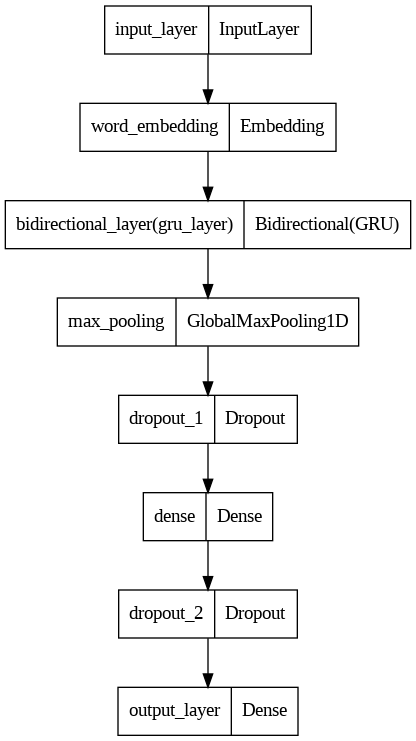

In [42]:
embedding_dim = 16

inputs = tf.keras.Input(shape=(max_seq_length,), name='input_layer')

embedding = tf.keras.layers.Embedding(
    input_dim=vocab_length,
    output_dim=embedding_dim,
    input_length=max_seq_length,
    name='word_embedding'
)(inputs)

gru_layer = tf.keras.layers.Bidirectional(
    tf.keras.layers.GRU(units=256, return_sequences=True, name='gru_layer'),
    name='bidirectional_layer'
)(embedding)

max_pooling = tf.keras.layers.GlobalMaxPool1D(name='max_pooling')(gru_layer)

dropout_1 = tf.keras.layers.Dropout(0.4, name='dropout_1')(max_pooling)

dense = tf.keras.layers.Dense(64, activation='relu', name='dense')(dropout_1)

dropout_2 = tf.keras.layers.Dropout(0.4, name='dropout_2')(dense)

outputs = tf.keras.layers.Dense(3, activation='softmax', name='output_layer')(dropout_2)


model = tf.keras.Model(inputs=inputs, outputs=outputs)

print(model.summary())

tf.keras.utils.plot_model(model)

In [43]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


batch_size = 32
epochs = 4

history = model.fit(
    train_inputs,
    train_labels,
    validation_split=0.12,
    batch_size=batch_size,
    epochs=epochs,
    verbose=2
)

Epoch 1/4
21/21 - 17s - loss: 0.9124 - accuracy: 0.4834 - val_loss: 0.7986 - val_accuracy: 0.5934 - 17s/epoch - 797ms/step
Epoch 2/4
21/21 - 13s - loss: 0.7989 - accuracy: 0.5196 - val_loss: 0.7923 - val_accuracy: 0.6703 - 13s/epoch - 604ms/step
Epoch 3/4
21/21 - 14s - loss: 0.7564 - accuracy: 0.5921 - val_loss: 0.7500 - val_accuracy: 0.7143 - 14s/epoch - 646ms/step
Epoch 4/4
21/21 - 14s - loss: 0.6603 - accuracy: 0.7145 - val_loss: 0.6834 - val_accuracy: 0.7143 - 14s/epoch - 678ms/step


In [44]:
model.evaluate(test_inputs, test_labels)

8/8 [==============================] - 2s 234ms/step - loss: 0.5647 - accuracy: 0.7849


[0.5647451281547546, 0.7848605513572693]

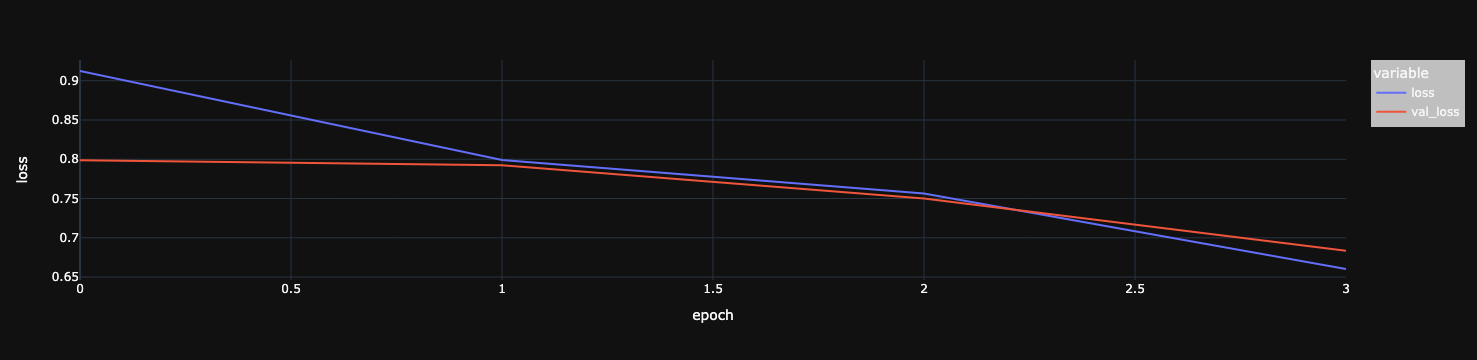

In [45]:
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "epoch", 'value': "loss"}
)

fig.show()

In [46]:
y_pred_prob = model.predict(test_inputs)
# test_labels

8/8 [==============================] - 2s 231ms/step


In [47]:
np.shape(y_pred_prob)

(251, 3)

In [48]:
test_labels

array([1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2,
       2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2,
       1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1,
       2, 1, 1, 2, 1, 1, 0, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1,
       2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1,
       2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 0, 1, 1, 1, 2,
       1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1,
       2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1,
       1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 0, 2, 1, 2,
       2, 2, 1, 1, 0, 2, 1, 1, 2])

In [49]:
# choose the one with max probability as the predicted class lable
y_pred = np.argmax(y_pred_prob, axis=1)
y_pred

array([1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1,
       2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2,
       1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1,
       2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2,
       1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1,
       2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2,
       1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2,
       1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1,
       2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1,
       1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2,
       2, 1, 1, 1, 1, 2, 1, 1, 1])

Plot the ROC curve and confusion matrix for multiclass.[ROC for multiclass - scikit-learn doc](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html). 

In [52]:
y_test_b = label_binarize(test_labels, classes=[0, 1, 2])
n_classes = y_test_b.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_b.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

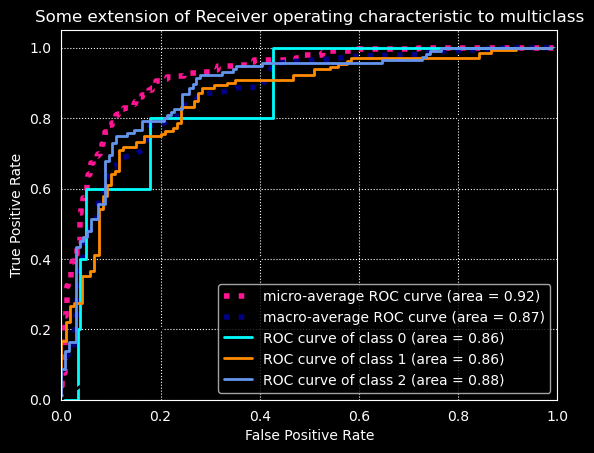

In [55]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

lw = 2

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [56]:
macro_roc_auc_ovo = roc_auc_score(y_test_b, y_pred_prob, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test_b, y_pred_prob, multi_class="ovo", average="weighted")

macro_roc_auc_ovr = roc_auc_score(y_test_b, y_pred_prob, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score( y_test_b, y_pred_prob, multi_class="ovr", average="weighted")

print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)

One-vs-One ROC AUC scores:
0.865877 (macro),
0.870059 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.865877 (macro),
0.870059 (weighted by prevalence)


In [57]:
y_pred = np.argmax(y_pred_prob, axis=1)
y_pred_b = label_binarize(y_pred, classes=[0, 1, 2])


multilabel_confusion_matrix(y_test_b, y_pred_b,  labels=[0, 1, 2])

array([[[246,   0],
        [  5,   0]],

       [[ 88,  32],
        [ 22, 109]],

       [[114,  22],
        [ 27,  88]]])

multilabel confusion matrix - class-wise (one vs rest): <br>
TN   |   FP   <br>
FN   |   TP

In [58]:
print(classification_report(y_test_b, y_pred_b))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.77      0.83      0.80       131
           2       0.80      0.77      0.78       115

   micro avg       0.78      0.78      0.78       251
   macro avg       0.52      0.53      0.53       251
weighted avg       0.77      0.78      0.78       251
 samples avg       0.78      0.78      0.78       251



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



There are 5 samples with negative sentiments, the model is not able to predict any of them. Can't do sampling due to the nature of the data being natural language. 

In [59]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['0','1','2'], 
                     columns = ['0','1','2'])

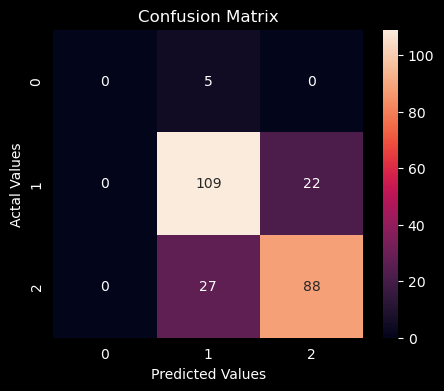

In [60]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

<a id='tldr'> </a>

# TL;DR

- Simple model based on individual words - [TextBlob](#textblob) produces very different sentiment scores from Nexidia's. 
- Deep learning model - [Bi-GRU](#gru): not many call transcripts with negative sentiment scores, hence even deep learning models is not able to classify negative call transcripts.